# Imports

In [25]:
import onnxruntime as ort
import numpy as np
import numpy.typing as npt
from pathlib import Path
import matplotlib.pyplot as plt

# Util

In [26]:
def sigmoid(x: npt.NDArray[np.float32]) -> np.float32:
    return 0.5 * ( np.tanh(x/2) + 1) # Numerically stable sigmoid
    

# Paths

In [27]:
ROOT: Path = Path('.').absolute().parent
DATADIR: Path = ROOT / 'data'
MODELDIR: Path = ROOT / 'models'

In [28]:
np_path: Path = DATADIR / 'bosh.axial.smri.t2_se.s0001.fp32.npy'
assert np_path.exists()

In [29]:
onnx_path: Path = MODELDIR / 'bosh.resnet18.axial.smri.t2_se.seg.brain.fp32.v1.0.0.onnx'
assert onnx_path.exists()

# Load Example

In [30]:
x_np: npt.NDArray[np.float32] = np.load(np_path)


In [31]:
x_np.shape # (slices/batch, channels, rows, columns)

(48, 1, 256, 256)

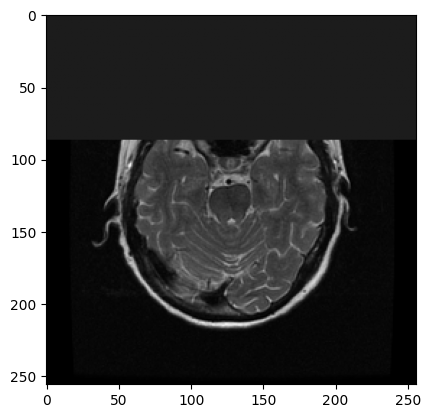

In [32]:
plt.imshow(x_np[16, 0, ...], cmap="gray")
plt.show()

# Load ONNX

In [33]:
model_ort: ort.InferenceSession = ort.InferenceSession(onnx_path)

In [34]:
input_node: ort.NodeArg = model_ort.get_inputs()[0]
output_node: ort.NodeArg = model_ort.get_outputs()[0]

# Run inference

In [35]:
y_hat_logits: npt.NDArray[np.float32] = model_ort.run(
    output_names=[output_node.name],
    input_feed={input_node.name: x_np}
)[0]

y_hat: npt.NDArray[np.float32] = sigmoid(y_hat_logits)

In [36]:
x_masked: npt.NDArray[np.float32] = np.where(
    y_hat > 0.5, 
    x_np, 
    x_np.min()
) 

In [41]:
def make_side_by_side_gif(arr1, arr2, arr3, filename, fps=8):
    import imageio
    arr1 = arr1.squeeze(1)
    arr2 = arr2.squeeze(1)
    arr3 = arr3.squeeze(1)

    frames = []

    for i in range(arr1.shape[0]):
        frame = np.concatenate(
            [arr1[i], arr2[i], arr3[i]], axis=1
        )

        frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-8)
        frame = (frame * 255).astype(np.uint8)

        frames.append(frame)

    frames = frames + frames[::-1]

    imageio.mimsave(filename, frames, duration=1/fps, loop=0 )

In [44]:
make_side_by_side_gif(x_np[1:-1], y_hat[1:-1], x_masked[1:-1], "bosh.axial.smri.t2_se.s0001.fp32.gif")